In [79]:

import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/the-movies-dataset/ratings.csv
/kaggle/input/the-movies-dataset/links_small.csv
/kaggle/input/the-movies-dataset/credits.csv
/kaggle/input/the-movies-dataset/keywords.csv
/kaggle/input/the-movies-dataset/movies_metadata.csv
/kaggle/input/the-movies-dataset/ratings_small.csv
/kaggle/input/the-movies-dataset/links.csv


In [3]:
from fastai.collab import *
from fastai.tabular.all import *


In [4]:
path= untar_data(URLs.ML_100k)

In [6]:
ratings= pd.read_csv(path/'u.data', delimiter= '\t', header= None,
                    names=['user','movie','rating','timestamp'])
ratings

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [16]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [18]:
ratings= ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [19]:
dls= CollabDataLoaders.from_df(ratings, item_name= 'title', bs= 64)
dls.show_batch()

,user,title,rating
0,7,Swiss Family Robinson (1960),4
1,566,"Return of the Pink Panther, The (1974)",5
2,104,Lone Star (1996),2
3,346,Under Siege 2: Dark Territory (1995),4
4,234,Apocalypse Now (1979),3
5,207,Tombstone (1993),3
6,719,Psycho (1960),4
7,328,Batman (1989),3
8,322,Raging Bull (1980),5
9,554,Sling Blade (1996),3


In [20]:
n_users= len(dls.classes['user'])
n_movies= len(dls.classes['title'])
n_factors= 5

user_factors= torch.randn(n_users, n_factors)
movie_factors= torch.randn(n_movies,n_factors)

In [21]:
one_hot_3= one_hot(3,n_users).float()

In [22]:
user_factors.t() @one_hot_3

tensor([ 0.3936, -1.1961, -0.1756, -0.2379,  1.0826])

In [23]:
user_factors[3]

tensor([ 0.3936, -1.1961, -0.1756, -0.2379,  1.0826])

In [26]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies,n_factors):
        self.user_factors= Embedding(n_users, n_factors)
        self.movie_factors= Embedding(n_movies, n_factors)
    def forward(self, x):
        users= self.user_factors(x[:,0])
        movies= self.movie_factors(x[:, 1])
        return (users*movies).sum(dim=1)

In [27]:
model = DotProduct(n_users, n_movies, 50)
learn= Learner(dls, model, loss_func= MSELossFlat())

In [28]:
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,1.333449,1.299067,00:08
1,1.073079,1.101884,00:08
2,0.981131,0.994353,00:08
3,0.865240,0.918646,00:08
4,0.810177,0.899570,00:08


In [40]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies,n_factors,y_range=(0,5.5)):
        self.user_factors= Embedding(n_users, n_factors)
        self.movie_factors= Embedding(n_movies, n_factors)
        self.y_range= y_range
        
    def forward(self, x):
        users= self.user_factors(x[:,0])
        movies= self.movie_factors(x[:, 1])
        return sigmoid_range((users*movies).sum(dim=1), *self.y_range)

In [41]:
model= DotProduct(n_users, n_movies, 50)
learn= Learner(dls, model, loss_func= MSELossFlat())
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,1.008252,0.998789,00:08
1,0.868243,0.910863,00:08
2,0.676503,0.867524,00:08
3,0.478596,0.871311,00:08
4,0.374973,0.876007,00:08


In [42]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [43]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.927450,0.946046,00:09
1,0.823578,0.858669,00:09
2,0.620747,0.854006,00:09
3,0.405733,0.875084,00:09
4,0.295661,0.881513,00:09


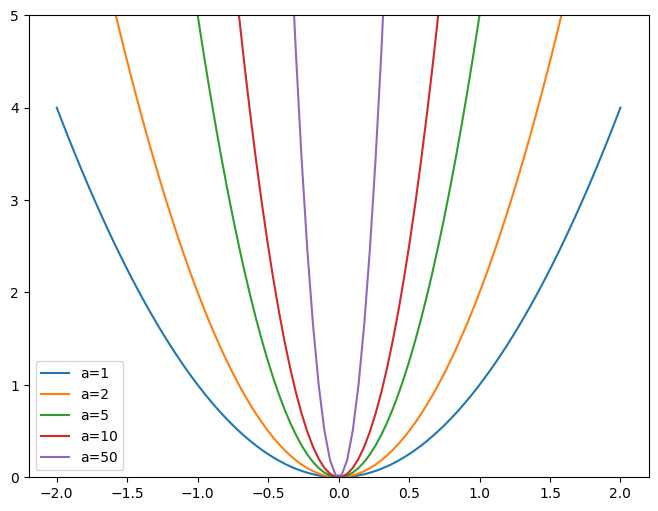

In [46]:
x= np.linspace(-2,2,100)
a_s= [1,2,5,10,50]
ys=[a*x**2 for a in a_s]
_, ax= plt.subplots(figsize=(8,6))
for a,y in zip(a_s, ys): ax.plot(x,y, label= f'a={a}')
ax.set_ylim([0,5])
ax.legend()

In [47]:
model = DotProductBias(n_users, n_movies, 50)
learn= Learner(dls, model,loss_func= MSELossFlat())
learn.fit_one_cycle(5,5e-3,wd= 0.1)

epoch,train_loss,valid_loss,time
0,0.940249,0.955742,00:09
1,0.844950,0.872092,00:09
2,0.731141,0.832441,00:09
3,0.585695,0.820090,00:09
4,0.483192,0.819513,00:09


In [48]:
class T(Module):
    def __init__(self): self.a= torch.ones(3)
L(T().parameters())

(#0) []

In [51]:
class T(Module):
    def __init__(self): self.a= nn.Parameter(torch.ones(3))
L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [52]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1,3,bias= False)
t=T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.9882],
        [-0.1647],
        [-0.1980]], requires_grad=True)]

In [53]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [54]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0,0.01))

In [58]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [59]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.946743,0.938896,00:09
1,0.886353,0.874636,00:09
2,0.703400,0.833083,00:09
3,0.594361,0.819435,00:09
4,0.464575,0.821556,00:09


In [60]:
movie_bias= learn.model.movie_bias.squeeze()
idxs= movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Mr. Magoo (1997)',
 'Solo (1996)',
 'Cable Guy, The (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)']

In [61]:
idxs = movie_bias.argsort(descending= True)[:5]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'Apt Pupil (1998)',
 'Titanic (1997)',
 "Schindler's List (1993)",
 'Good Will Hunting (1997)']

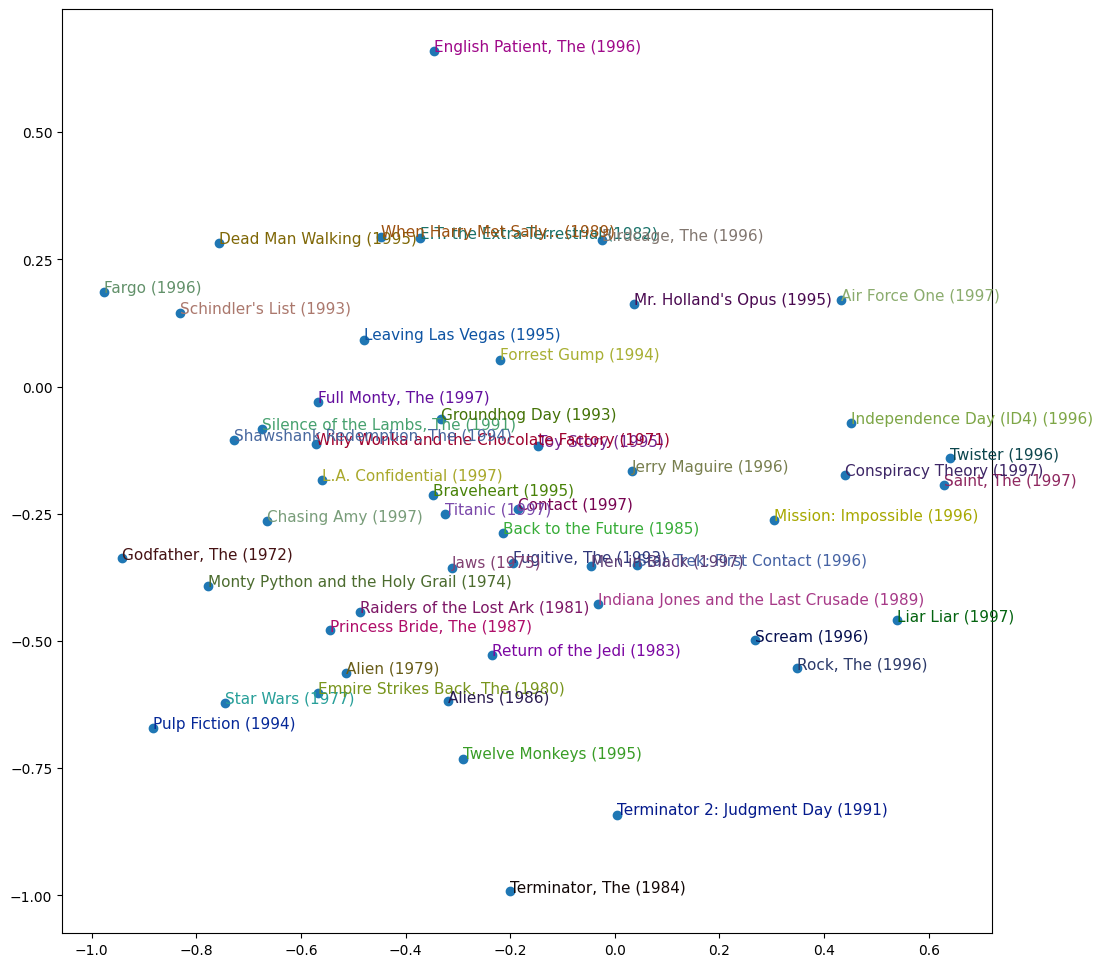

In [62]:
g= ratings.groupby('title')['rating'].count()
top_movies= g.sort_values(ascending= False).index.values[:1000]
top_idxs= tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w= learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca= movie_w.pca(3)
fac0,fac1,fac2= movie_pca.t()
idxs= list(range(50))
X= fac0[idxs]
Y= fac2[idxs]
plt.figure(figsize= (12,12))
plt.scatter(X,Y)
for i, x, y in zip(top_movies[idxs],X,Y):
    plt.text(x,y,i, color= np.random.rand(3)*0.7, fontsize= 11)
plt.show()

In [63]:
learn= collab_learner(dls, n_factors= 50, y_range= (0,5.5))


In [64]:
learn.fit_one_cycle(5,5e-3, wd= 0.1)

epoch,train_loss,valid_loss,time
0,0.924155,0.944731,00:09
1,0.854807,0.881924,00:09
2,0.741962,0.835200,00:09
3,0.584557,0.817500,00:09
4,0.508691,0.818177,00:09


In [65]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [66]:
movie_bias= learn.model.i_bias.weight.squeeze()
idxs= movie_bias.argsort(descending= True)[:5]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'Titanic (1997)',
 'Good Will Hunting (1997)',
 "Schindler's List (1993)",
 'Apt Pupil (1998)']

In [67]:
movie_factors= learn.model.i_weight.weight
idx= dls.classes['title'].o2i['Shawshank Redemption, The (1994)']
distances= nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx= distances.argsort(descending= True)[1]
dls.classes['title'][idx]

'Prefontaine (1997)'

In [68]:
embs= get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [72]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [73]:
model= CollabNN(*embs)

In [74]:
learn= Learner(dls,model,loss_func= MSELossFlat())
learn.fit_one_cycle(5,5e-3,wd=0.01)

epoch,train_loss,valid_loss,time
0,0.934402,0.947774,00:12
1,0.884882,0.908755,00:10
2,0.903158,0.892160,00:09
3,0.802592,0.871739,00:09
4,0.773641,0.875132,00:10


In [75]:
learn= collab_learner(dls, use_nn= True, y_range= (0,5.5), layers= [100,50])
learn.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.995817,1.002790,00:11
1,0.896291,0.920638,00:11
2,0.862808,0.886667,00:11
3,0.852852,0.869060,00:11
4,0.750564,0.872403,00:11


In [77]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers= layers, n_cont=0, out_sz=1, **kwargs)